# Feature Extraction

In [8]:
import os
import json
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import scipy.stats as ss
from skimage.feature import local_binary_pattern
from skimage.restoration import denoise_wavelet
from sklearn import cross_validation


def get_crop_areas(h, w):
    center_x = h//2-(512//2)
    center_y = w//2-(512//2)
    return {
        'top-left': (0, 0, 512, 512),
        'bottom-right': (h-512, w-512, h, w),
        'bottom-left': (h-512, 0, h, 512),
        'top-right': (0, w-512, 512, w),
        'center-center': (center_x, center_y, center_x+512, center_y+512)
    }


def get_stat_features(noise, prefix):
    noise_features = {
        prefix + '_mean': np.mean(noise),
        prefix + '_std': np.std(noise),
        prefix + '_median': np.median(noise),
        prefix + '_min': np.min(noise),
        prefix + '_max': np.max(noise),
        prefix + '_sum': np.sum(noise),
        prefix + '_kurtosis': ss.kurtosis(noise.flatten()),
        prefix + '_skewness': ss.skew(noise.flatten()),
        prefix + '_variation': ss.variation(noise.flatten()),
        prefix + '_non_zero_mean': np.mean(noise[noise > 0]),
        prefix + '_low_value_count': (noise < 0.2).sum(),
        prefix + '_high_value_count': (noise > 0.8).sum()
    }
#     print(ss.kurtosis(noise.flatten()))
    return noise_features


def format_(name, values):
    return {'{}{}'.format(name, i): v for i, v in enumerate(values)}

def get_image_features(img):    
#     img_denoised = denoise_wavelet(img, multichannel=True)
    img_denoised = cv2.fastNlMeansDenoisingColored(img) # cv2.fastNlMeansDenoising(img)
    noise = (img/255) - img_denoised
    noise[np.isnan(noise)] = 0
#     print(img_denoised.shape)
#     plt.imshow(img_denoised)
#     plt.imshow(noise)
    if noise.mean() == 0.0:
        noise = np.zeros(shape=(512,512,3), dtype=float)

    features = {}
    # Noise features
    features.update(get_stat_features(noise[:,:,0], 'noise_stat_r'))
    features.update(get_stat_features(noise[:,:,1], 'noise_stat_g'))
    features.update(get_stat_features(noise[:,:,2], 'noise_stat_b'))

    features.update(format_('noise_hist_r', np.histogram(noise[:,:,0], bins=256)[0]))
    features.update(format_('noise_hist_g', np.histogram(noise[:,:,1], bins=256)[0]))
    features.update(format_('noise_hist_b', np.histogram(noise[:,:,2], bins=256)[0]))

    noise_lbp_r = local_binary_pattern(noise[:,:,0], 8, 3)
    noise_lbp_g = local_binary_pattern(noise[:,:,1], 8, 3)
    noise_lbp_b = local_binary_pattern(noise[:,:,2], 8, 3)       
    features.update(format_('noise_hist_lbp_r', np.histogram(noise_lbp_r, bins=256)[0]))
    features.update(format_('noise_hist_lbp_g', np.histogram(noise_lbp_g, bins=256)[0]))
    features.update(format_('noise_hist_lbp_b', np.histogram(noise_lbp_b, bins=256)[0]))

    features.update(get_stat_features(noise_lbp_r, 'noise_lbp_stat_r'))
    features.update(get_stat_features(noise_lbp_g, 'noise_lbp_stat_g'))
    features.update(get_stat_features(noise_lbp_b, 'noise_lbp_stat_b'))

    # Image features
    features.update(format_('img_hist_r', np.histogram(img[:,:,0], bins=256)[0]))
    features.update(format_('img_hist_g', np.histogram(img[:,:,1], bins=256)[0]))
    features.update(format_('img_hist_b', np.histogram(img[:,:,2], bins=256)[0]))

    lbp_r = local_binary_pattern(img[:,:,0], 8, 3)
    lbp_g = local_binary_pattern(img[:,:,1], 8, 3)
    lbp_b = local_binary_pattern(img[:,:,2], 8, 3)  
    features.update(format_('img_hist_lbp_r', np.histogram(lbp_r, bins=256)[0]))
    features.update(format_('img_hist_lbp_g', np.histogram(lbp_g, bins=256)[0]))
    features.update(format_('img_hist_lbp_b', np.histogram(lbp_b, bins=256)[0]))

    features.update(format_('img_hist_lbp_r_ed', np.histogram(lbp_r, bins=256)[1]))
    features.update(format_('img_hist_lbp_g_ed', np.histogram(lbp_g, bins=256)[1]))
    features.update(format_('img_hist_lbp_b_ed', np.histogram(lbp_b, bins=256)[1]))
#     print(features)
    return features


def get_path_features(path, verbose=False):
    features_list = []
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    for angle in [0]:#, 90, 90, 90]:
        if angle != 0:
            img = np.rot90(img)
        (h, w) = img.shape[:2]
        for crop_area, (x1, y1, x2, y2) in get_crop_areas(h, w).items():
            features = get_image_features(img[x1:x2, y1:y2])
            features.update({
                'device': os.path.basename(os.path.dirname(path)),
                'filename': os.path.basename(path),
                'crop_area': crop_area
            })
            features_list.append(features)
    return features_list


def save_all_features(paths, output, verbose=False):
    features_list = []
    for path in tqdm_notebook(paths):
        print(path)
        features_list.extend(get_path_features(path, verbose))   
    df = pd.DataFrame(features_list)
    df.to_pickle(output)

# paths = ['/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)29.jpg']
paths = ['test/img_0ac09ab_manip.tif', 'test/img_0ae48a7_unalt.tif']
# paths = ['test/img_4f13d10_unalt.tif',  'test/img_4b25b5e_unalt.tif',  'test/img_2ea3452_manip.tif' , 'test/img_2cdfd34_unalt.tif',  'test/img_1cd317d_manip.tif',  'test/img_3f1aa09_manip.tif',  'test/img_4bbcc86_manip.tif']
save_all_features(paths, 'df_sample.pkl', True)

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

test/img_0ac09ab_manip.tif


/home/p4w/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/p4w/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test/img_0ae48a7_unalt.tif



In [74]:
img = cv2.imread('test/img_1b3af7a_unalt.tif')

lbp_r = local_binary_pattern(img[:,:,0], 8, 3)
# plt.imshow(lbp_r)
lbp_r.shape
# color = ('b','g','r')
# for channel,col in enumerate(color):
histr = cv2.calcHist([lbp_r],[0],None)
plt.plot(histr,color = col)
#     plt.xlim([0,256])
# plt.title('Histograma por canal')
# plt.show()


TypeError: Required argument 'histSize' (pos 4) not found

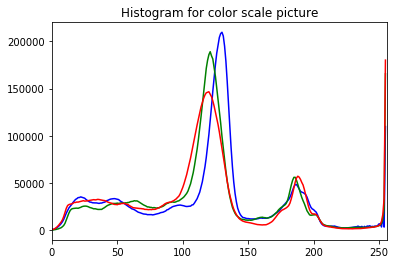

In [43]:
img = cv2.imread('train/iPhone-4s/(iP4s)1.jpg')

color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

In [ ]:
%%time
from datetime import datetime

paths = []
base_dir = '/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original'
for device_dir in os.listdir(base_dir):
    for file in os.listdir(os.path.join(base_dir, device_dir)):
        paths.append(os.path.join(base_dir, device_dir, file))


# print(paths)
print('Extracting features of {} images...'.format(len(paths)))
print('Started at {}'.format(datetime.now()))
save_all_features(paths, 'df_color.pkl')
print('Finished at {}'.format(datetime.now()))

Extracting features of 2750 images...
Started at 2018-04-25 08:20:28.737350


HBox(children=(IntProgress(value=0, max=2750), HTML(value='')))

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)36.jpg


/home/p4w/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/p4w/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)195.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)163.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)126.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)161.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)25.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)268.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)252.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)231.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)142.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)245.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)51.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)76.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)133.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)223.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)7.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)6.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)179.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)256.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)257.

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)180.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)197.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)186.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)236.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)125.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)98.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)150.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)114.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)83.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)167.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)61.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)56.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)205.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)79.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)88.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)153.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)184.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)187.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-X/(MotoX)25

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)49.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)152.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)268.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)267.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)31.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)275.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)30.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)116.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)229.jpg
/hom

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)134.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)262.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)45.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)164.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)248.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)193.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)227.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)83.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)129.jpg
/ho

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)255.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)186.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)94.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)204.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)263.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)81.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)173.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)168.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)175.jpg
/ho

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-S4/(GalaxyS4)12.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)30.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)70.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)224.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)184.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)22.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)195.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)159.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)51.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)97.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)201.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)212.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)130.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)27.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)175.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)71.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)192.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)220.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)1

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)169.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)105.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)221.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)99.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)37.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)112.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)1.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)140.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)96.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)203

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)151.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)118.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)115.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)257.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)101.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)186.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)132.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)255.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5x)249.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/LG-Nexus-5x/(LG5

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)54.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)180.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)7.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)159.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)249.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)230.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)167.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)163.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)139.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)247.JPG
/ho

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)80.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)263.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)210.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)189.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)2.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)143.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)219.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)118.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)61.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)31.JPG
/home

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)195.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)213.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)244.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)79.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)172.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)52.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)262.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)132.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)179.JPG
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Sony-NEX-7/(Nex7)97.JPG
/ho

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)25.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)60.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)131.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)91.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)154.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)118.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)144.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)267.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-N

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)38.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)23.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)269.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)22.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)104.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)65.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)174.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)243.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-No

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)238.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)11.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)214.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)92.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)192.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)66.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)3.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)194.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Not

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)273.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)272.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)21.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)59.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)87.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)221.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)148.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-Note3/(GalaxyN3)14.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Samsung-Galaxy-No

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)37.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)174.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)146.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)194.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)164.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)41.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)161.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)247.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)255.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)132.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)172.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)213.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)24.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)252.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)143.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)135.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)47.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)275.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)148.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)274.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)182.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)5.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)216.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)231.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)166.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)82.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(HTC-1-M7)263.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/HTC-1-M7/(

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)254.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)3.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)118.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)117.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)154.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)168.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)185.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)189.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)268.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)196.jpg
/home/p4w/Documentos/mestrado/pr

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)47.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)55.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)32.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)226.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)11.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)41.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)108.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)24.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)164.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)222.jpg
/home/p4w/Documentos/mestrado/practi

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)258.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)267.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)273.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)249.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)38.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)260.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)13.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)151.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)221.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)152.jpg
/home/p4w/Documentos/mestrado/pr

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)35.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)30.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)177.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)91.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)240.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)175.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/iPhone-6/(iP6)162.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)130.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)175.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)11

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)237.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)20.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)137.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)126.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)55.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)269.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)138.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)7.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)262.jpg
/home/p4w/Docu

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)216.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)19.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)65.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)52.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)46.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)167.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)33.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)210.jpg
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/train-original/Motorola-Nexus-6/(MotoNex6)187.jpg
/home/p4w/Docum

## Carregando base de teste

In [5]:
%%time
from datetime import datetime

paths = []
base_dir = '/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original'
# for device_dir in os.listdir(base_dir):
for file in os.listdir(base_dir):
    paths.append(os.path.join(base_dir, file))
      
print('Extracting features of {} images...'.format(len(paths)))
print('Started at {}'.format(datetime.now()))
save_all_features(paths, 'df_test_final.pkl')
print('Finished at {}'.format(datetime.now()))

Extracting features of 2640 images...
Started at 2018-04-25 05:23:02.340564


HBox(children=(IntProgress(value=0, max=2640), HTML(value='')))

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fe88335_unalt.tif


/home/p4w/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/p4w/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ee058bd_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b2e6733_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b9b8889_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_a6b1c89_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8890243_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e1b9edd_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0b95b66_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_2244eb5_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1c6b96f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0197115_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e14f959_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4308662_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b039656_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_12473ab_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9c10d2f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_78464dd_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_57e041a_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f0237a8_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_dd92980_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fd991f9_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3c38525_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f661fad_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_80745a0_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3666cd3_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9543f5b_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5e860ef_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_eceebe8_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3405b8c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5e1052d_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4496408_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9e07b25_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b74b7d4_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ee2c259_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5366cee_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c4ee568_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0f62863_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c2ba760_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_bb1ff2b_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_a53e511_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_25531fd_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4015497_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3b50407_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_882c281_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1e47422_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_aa4e840_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c692fb6_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4bca669_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_99cbb6f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6aa23d5_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4696039_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_aa16ead_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6902219_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0390cee_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_bef22df_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1561e68_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0e4829b_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_325c7cc_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_75a3777_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6255cc1_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5d30673_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_632dfc0_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6dbd8db_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5af52e8_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_311aa3a_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_99eb725_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_10c350e_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_008fb06_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9d210c5_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6dbfe1c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_dc7a41f_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_a0117a2_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c944786_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1b2efcb_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fd4edba_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4ef67b5_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ed3cb54_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_06d0df5_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fe5e328_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_75ba5e6_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7d1ce80_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_93c56d7_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_56a5e2d_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_602796d_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b508d5f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4ca742b_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d06d147_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0f43170_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fc5d735_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ced5c14_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_93646c4_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c47fd23_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_959138c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8026ed4_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e18199a_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ea1c998_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_802ad25_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_47cb3f3_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_739d699_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7636305_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_07946c1_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d08048c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_416f612_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_06a4a46_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_adeac07_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e64cb24_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5d24f2c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1effab4_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1eb9d8f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d8df827_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1f68a70_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_57c05bf_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_553cee6_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_2fce2c2_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d1b249e_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e64a308_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ab0fa75_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7d9ca19_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3933c44_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_df54047_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e4ba607_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_84ba43d_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f2b9803_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f3ae5ea_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3acc6b6_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_acce035_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_97c44e9_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ae6f9eb_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0d14e4e_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_dea1856_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e24f52d_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6512040_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6e78af6_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8bbf030_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9afad85_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_cba1c42_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_78f3a46_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_85ab377_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5990965_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f388a9d_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ab97c0e_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_136bf22_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6ab6b9d_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_62eb864_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0477f29_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_25493b1_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_15e8df3_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8408e35_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_baaf8f3_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1e5ffae_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d30e30f_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0d53904_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_03e34e4_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0f0b1f1_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b46460f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d34dc99_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5d26b47_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1073b1f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_bf4f92b_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ca9137c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7338a30_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_715c07a_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6dd512f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_04801fb_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9a81512_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_68a45e9_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_decc77e_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_701167b_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c3920e2_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e847214_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7daaf99_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_eeae949_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_17eda59_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8749dde_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ab11de9_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c62cab6_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0bdc6ce_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_709e6d7_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_30d223c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_69fdd9f_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e16d9c1_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b6f1854_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7a7574b_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_97d1192_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_40a9f09_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_bc69551_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_eaa00bc_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_90196ff_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_072619c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4249f91_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_a4e7fe6_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_52ba50e_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fb8d0ae_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7815efc_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c6bd39c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1fb48da_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3c95909_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_cfe17e9_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_2b16b3f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d32f7ac_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6d29846_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4f13d10_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_68fa833_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4b25b5e_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f979bdf_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_70ec117_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8e679c1_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_47f08fd_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5f4f4f6_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8a9dce9_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_21903dc_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_472254f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_2753367_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9e8b030_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0f7c5d5_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_27ba2bb_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ab25529_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e7a0a1a_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ee9a22c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7ee7122_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9530795_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fd031b9_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4a91ce8_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fc35c97_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6a7b1ef_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_2b74280_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_917816d_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_65524a5_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ddcaede_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d4df8c2_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_129f650_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8fb50f2_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_48c08f4_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5accc28_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_62b2b45_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_a537605_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c330a00_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_268ab37_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_cc70d01_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_86a67fd_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_ebecf54_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d93acda_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0e02d7c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_de5a87f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f051a55_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b1a7208_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4db24f4_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8b43dcc_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8dd4add_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5b2f4fd_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_809c0ad_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_1b3af7a_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_8a59330_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_423548c_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_505c0ef_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_88bdaec_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_229bd5b_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f088528_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c65cb5e_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_5294c7c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_c568e1b_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_cada90d_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fbce182_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7f243ee_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6cfa280_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f500caa_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_2182974_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_dce2359_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4581af5_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3e79b1e_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_26ef277_manip.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_fe9e387_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0b9b529_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3c6976b_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3135be9_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_342adef_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_26e435d_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b904f62_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_675c42f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_be81a72_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6df37f2_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7536a8d_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_caa18ae_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4438c18_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_bcf5cbc_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0875b1c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f38cfe6_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_4561f28_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_d05de1c_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_7fece20_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_820daf3_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9ed6293_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3544f50_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3ac4275_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_f678fce_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_39b9a2f_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_34cf395_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_a5a4794_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_714f4c6_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_00275cf_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_68c25fd_unalt.tif
/home/p4w/Documentos/mestrado/practical_

/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_54b1c14_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_9ae9258_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_b196e87_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_e08ccfb_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_0609bc8_unalt.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_414a368_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_3d270e8_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_6ecbf8d_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_953b8fd_manip.tif
/home/p4w/Documentos/mestrado/practical_assingments/pract_2/test-original/img_adc2912_manip.tif
/home/p4w/Documentos/mestrado/practical_

# Train Model

In [14]:
import pandas as pd
import numpy as np

df_train = pd.read_pickle('df_color.pkl')
# df_test = pd.read_pickle('df_test_final.pkl')
print(len(df_train))
# df_train.idxmax

300


In [16]:
df_train.fillna(0, inplace=True)
# df_test.fillna(0, inplace=True)

In [17]:
df_train.replace(np.inf, 0, inplace=True)
df_train.replace(-np.inf, 0, inplace=True)

# df_test.replace(np.inf, 0, inplace=True)
# df_test.replace(-np.inf, 0, inplace=True)


# ML model

In [18]:
all_features = df_train.columns.drop(['device', 'filename', 'crop_area'])
noise_features = df_train.head(1).filter(regex='.*noise.*', axis=1).columns
lbp_features = df_train.head(1).filter(regex='.*lbp.*', axis=1).columns

# t_all_features = df_test.columns.drop(['device', 'filename', 'crop_area'])
# t_noise_features = df_test.head(1).filter(regex='.*noise.*', axis=1).columns
# t_lbp_features = df_test.head(1).filter(regex='.*lbp.*', axis=1).columns

In [22]:
from sklearn.model_selection import StratifiedKFold
features = df_train.columns.drop(['device', 'filename', 'crop_area'])
#features = df_train.head(1).filter(regex='.*hist.*', axis=1).columns
X = df_train[noise_features].values
y = df_train['device'].values
n_classes = df_train.device.nunique()

cv = StratifiedKFold(5, True, 1986)

print("Feautures: {}".format(len(noise_features)))

# # features = df_test.columns.drop(['device', 'filename'])
# #features = df_train.head(1).filter(regex='.*hist.*', axis=1).columns
# Xt = df_test[t_all_features].values
# # yt = df_test['device'].values
# n_classest = df_test.device.nunique()

# print("Feautures: {}".format(len(lbp_features)))
# df_train.device.unique()

Feautures: 1608


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                    stratify=y, random_state=1986)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 2358), (60, 2358), (240,), (60,))

## Random Forest

In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

classifier = RandomForestClassifier(100, random_state=1986)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
print(scores, scores.mean())

[0.45       0.51666667 0.43333333 0.46666667 0.56666667] 0.4866666666666667
CPU times: user 1.78 s, sys: 3.93 ms, total: 1.78 s
Wall time: 1.78 s


In [16]:
classifier.fit(X,y)

class1 = classifier.predict(Xt)
class1.size

2640

In [25]:
class1.shape

(13200,)

## Logistic Regression

In [24]:
%%time
from sklearn.linear_model import LogisticRegression

classifier2 = LogisticRegression(random_state=1986, solver='newton-cg', multi_class='multinomial')
scores2 = cross_val_score(classifier2, X, y, scoring='accuracy', cv=cv)
print(scores2, scores2.mean())

/home/p4w/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/p4w/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/p4w/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/p4w/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[0.46666667 0.45       0.43333333 0.4        0.46666667] 0.44333333333333336
CPU times: user 1min 21s, sys: 120 ms, total: 1min 21s
Wall time: 1min 21s


/home/p4w/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [43]:
classifier2.fit(X,y)
class2 = classifier2.predict(Xt)
class2.shape

/home/p4w/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(2640,)

## eXtreme Gradient Boost

In [ ]:
%%time
import xgboost as xgb

classifer3 = xgb.XGBClassifier(seed=1986, nthread=-1)
scores3 = cross_val_score(classifer3, X, y, scoring='accuracy', cv=cv)
print(scores3, scores3.mean())

## Neural Network

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_num = le.fit_transform(y)

In [29]:
import tensorflow as tf
import tflearn
from sklearn.preprocessing import StandardScaler

tf.reset_default_graph()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# Xt = scaler.transform(Xt)

targets = np.unique(y_num)
y_num2 = (y_num.reshape((-1, 1)) == targets).astype(np.uint8)

input_layer = tflearn.input_data((None, len(noise_features)))
net = tflearn.fully_connected(input_layer, 1700, activation='relu')
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, 1700, activation='relu')
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, n_classes, activation='softmax')
net = tflearn.regression(net, learning_rate=1e-3)
model = tflearn.DNN(net, tensorboard_verbose=3, tensorboard_dir='tensorboard')

In [4]:
y_num2.shape, X.shape


NameError: name 'y_num2' is not defined

In [30]:
model.fit(X, y_num2, n_epoch=15, batch_size=2200, show_metric=True, shuffle=True) # validation_set=(X_val, y2_val),

---------------------------------
Run id: XH85EE
Log directory: tensorboard/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 300
Validation samples: 0
--
Training Step: 1  | time: 5.336s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 -- iter: 300/300
--
Training Step: 2  | total loss: 2.08861 | time: 0.509s
| Adam | epoch: 002 | loss: 2.08861 - acc: 0.0990 -- iter: 300/300
--
Training Step: 3  | total loss: 1.63818 | time: 0.430s
| Adam | epoch: 003 | loss: 1.63818 - acc: 0.4216 -- iter: 300/300
--
Training Step: 4  | total loss: 1.31021 | time: 0.325s
| Adam | epoch: 004 | loss: 1.31021 - acc: 0.5729 -- iter: 300/300
--
Training Step: 5  | total loss: 0.95939 | time: 0.307s
| Adam | epoch: 005 | loss: 0.95939 - acc: 0.7001 -- iter: 300/300
--
Training Step: 6  | total loss: 0.77785 | time: 0.329s
| Adam | epoch: 006 | loss: 0.77785 - acc: 0.7558 -- iter: 300/300
--
Training Step: 7  | total 

In [23]:
class3 = model.predict(Xt)
# targets[np.argmax(class3)]

In [24]:
classes = le.classes_
camera = []
for y in class3:
    max_index = y.argmax(axis=0)
    camera.append(classes[max_index])
len(camera)

2640

## gerar .CSV Kaggle

In [18]:
import csv
with open('csvALLLR.csv', 'w') as myfile:
    wr = csv.writer(myfile)#, quotechar='"', quoting=csv.QUOTE_ALL)
    columnTitleRow = [u''.join('fname') + ";" + u''.join('camera')]
    wr.writerow(columnTitleRow)
    for item in range(0, len(df_test['filename'])):
        wr.writerow([u''.join(df_test['filename'][item]) + ";" + u''.join(class1[item])])

In [44]:
import csv
with open('csvALLLR.csv', 'w') as myfile:
    wr = csv.writer(myfile)#, quotechar='"', quoting=csv.QUOTE_ALL)
    columnTitleRow = [u''.join('fname') + ";" + u''.join('camera')]
    wr.writerow(columnTitleRow)
    for item in range(0, len(df_test['filename'])):
        wr.writerow([u''.join(df_test['filename'][item]) + ";" + u''.join(class2[item])])

In [25]:
import csv
with open('csv_NN.csv', 'w') as myfile:
    wr = csv.writer(myfile)#, quotechar='"', quoting=csv.QUOTE_ALL)
    columnTitleRow = [u''.join('fname') + ";" + u''.join('camera')]
    wr.writerow(columnTitleRow)
    for item in range(0, len(df_test['filename'])):
        wr.writerow([u''.join(df_test['filename'][item]) + ";" + u''.join(camera[item])])

In [74]:
class2.shape

(2640,)

In [188]:
df_kaggle = pd.read_csv('sample.csv')
df_kaggle.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-6
1,img_001e31c_unalt.tif,iPhone-6
2,img_00275cf_manip.tif,iPhone-6
3,img_0034113_unalt.tif,iPhone-6
4,img_00344b7_unalt.tif,iPhone-6


In [189]:
df_kaggle.camera = class2

In [190]:
df_kaggle.head()

,fname,camera
0,img_0002a04_manip.tif,Motorola-Nexus-6
1,img_001e31c_unalt.tif,Motorola-Nexus-6
2,img_00275cf_manip.tif,iPhone-6
3,img_0034113_unalt.tif,iPhone-6
4,img_00344b7_unalt.tif,Motorola-Nexus-6
